In [1]:
from aart_func import *
from params import * # The file params.py contains all the relevant parameters for the simulations
from astropy import units as u
import kgeo
import tools as tls
import subprocess
import scipy.interpolate
from matplotlib import ticker
%load_ext autoreload
%autoreload 2
import importlib 
from functools import partial


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca
Welcome to eht-imaging! v 1.2.5 


# Computation of the lensing bands

In [3]:
%time !python3 lensingbands.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Computing the lensing bands
Number of points in the n=0 grid  6250000
Number of points in the n=1 grid  6250000
Number of points in the n=2 grid  6250000
File  ./Results/LensingBands_a_0.94_i_17.h5  created.
CPU times: user 419 ms, sys: 85.9 ms, total: 505 ms
Wall time: 39.5 s


In [2]:
fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])

h5f.close()

Reading file:  ./Results/LensingBands_a_0.94_i_17.h5


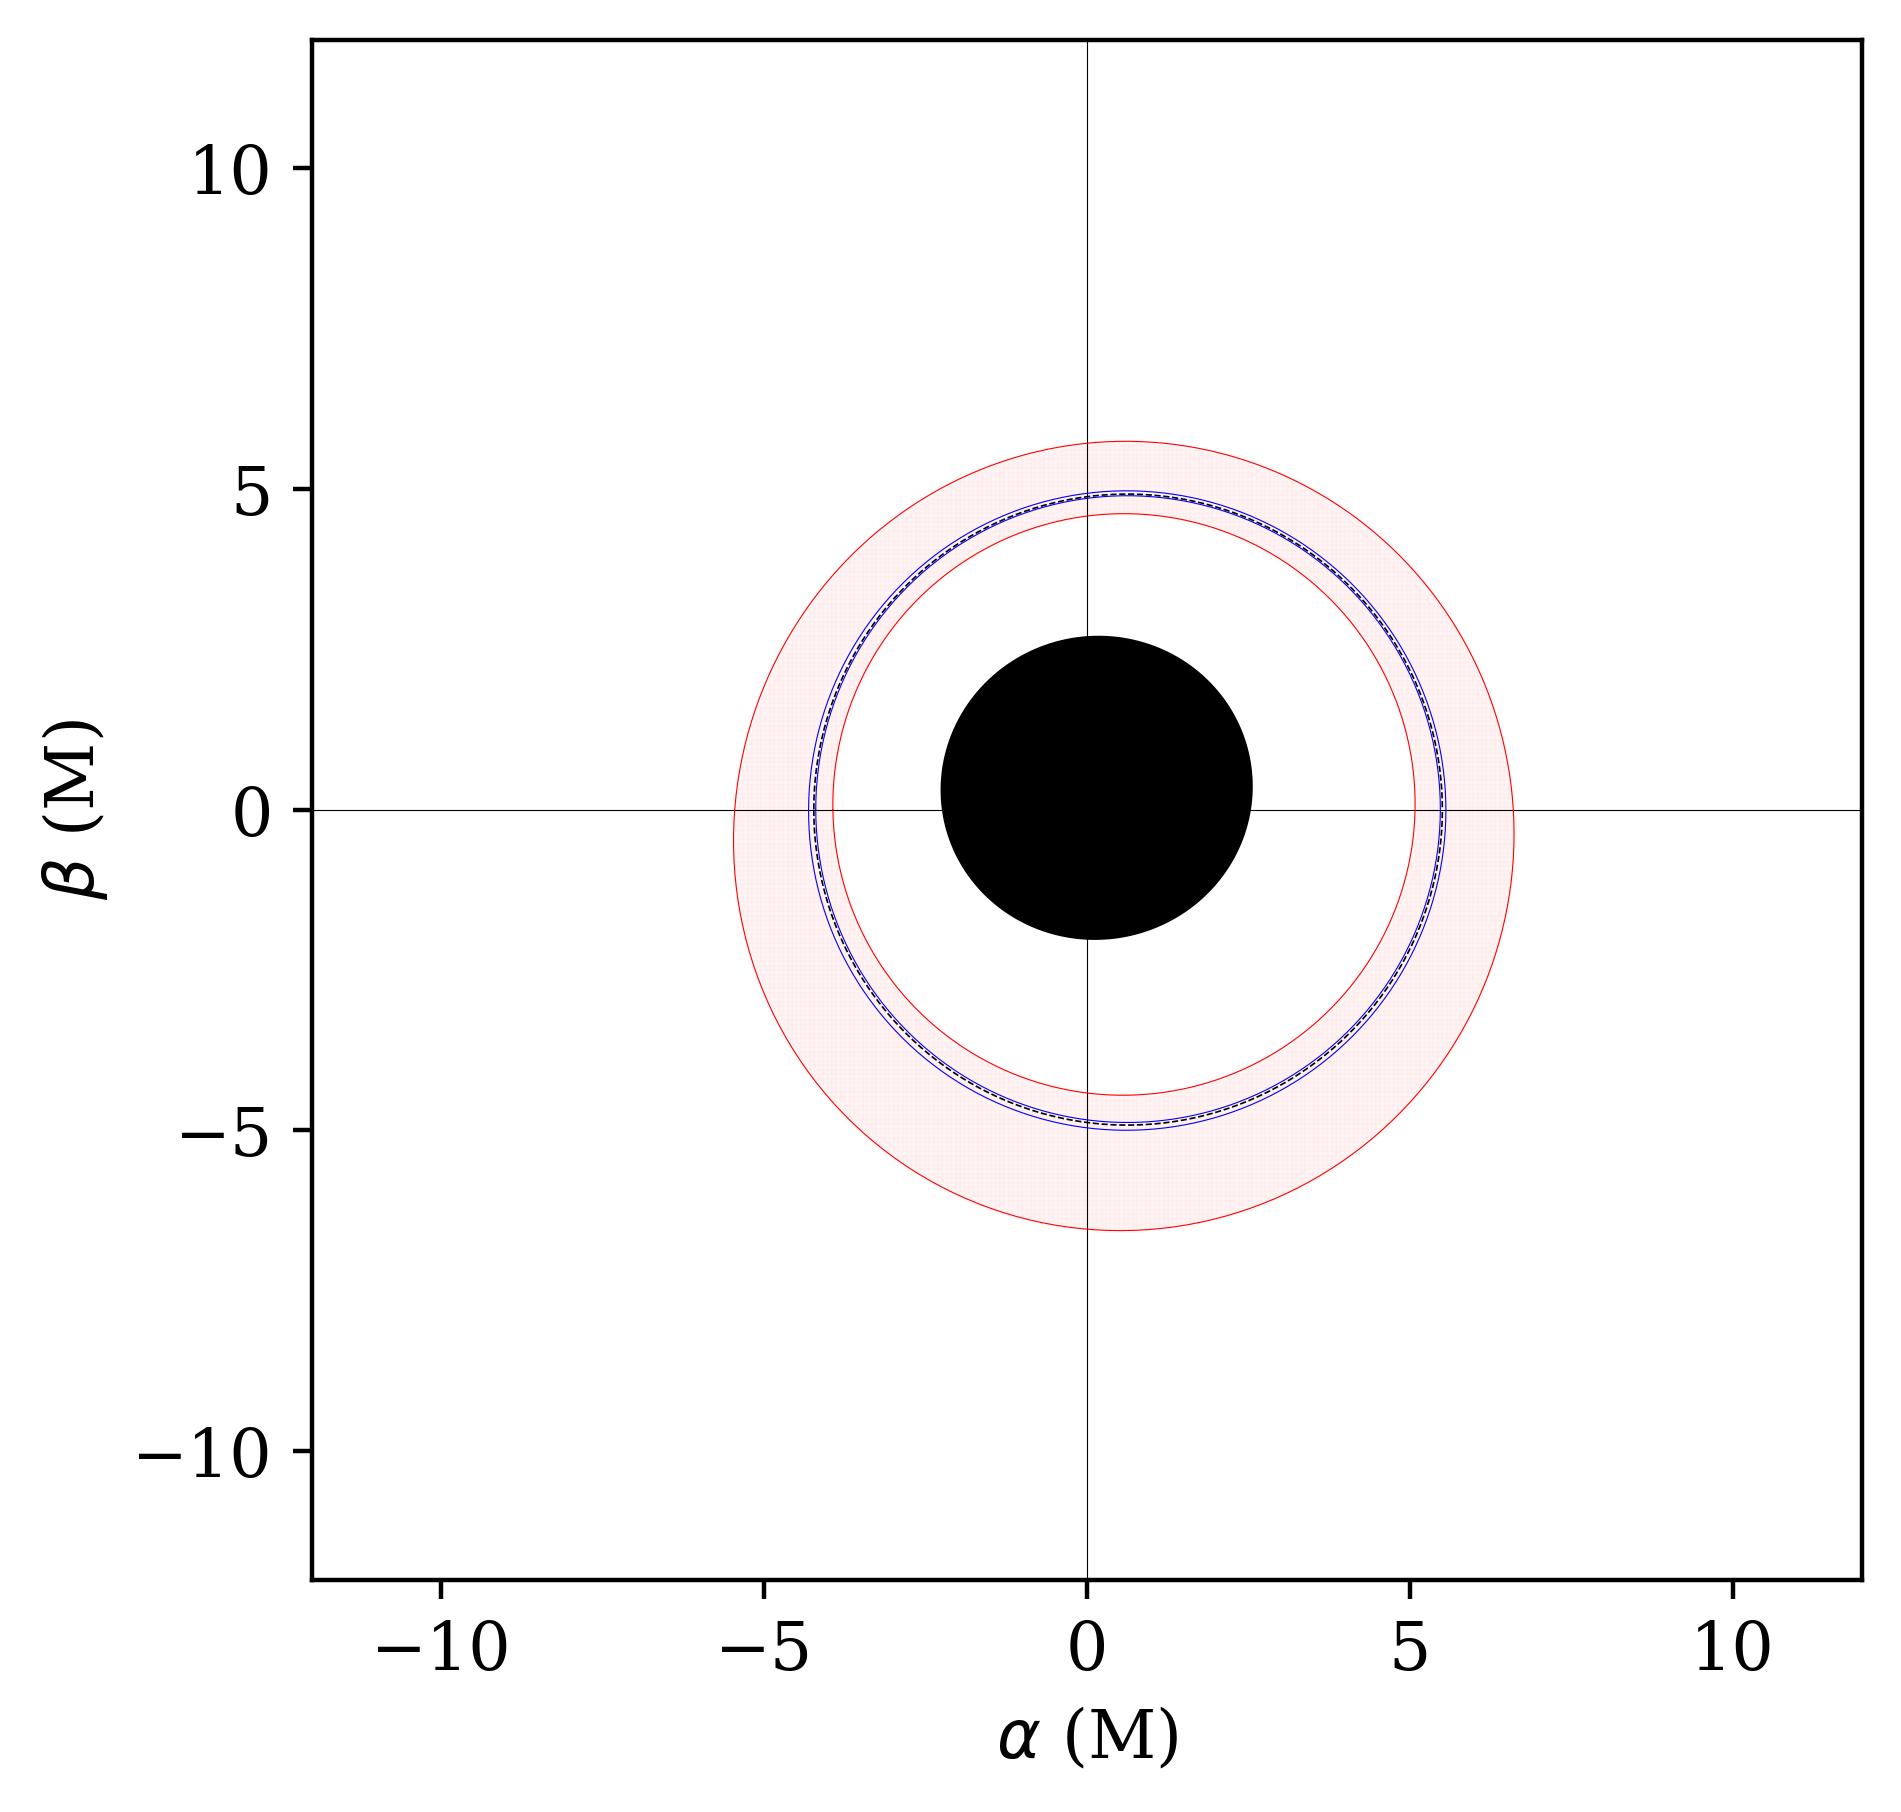

In [3]:
fig, ax = plt.subplots(figsize=[5,5],dpi=400)

ax.axvline(0,color="k",linewidth=0.2)
ax.axhline(0,color="k",linewidth=0.2)

ax.plot(alpha_critc,beta_critc,color="k",linewidth=0.3,linestyle="--")
ax.plot(alpha_critc,-beta_critc,color="k",linewidth=0.3,linestyle="--")

ax.fill(hull_0i[:,0],hull_0i[:,1],color="k")
ax.plot(hull_1i[:,0],hull_1i[:,1],'r',linewidth=0.2)
ax.plot(hull_1e[:,0],hull_1e[:,1],'r',linewidth=0.2)
ax.plot(hull_2i[:,0],hull_2i[:,1],'b',linewidth=0.2)
ax.plot(hull_2e[:,0],hull_2e[:,1],'b',linewidth=0.2)

#Plotting the grid points of the n=1 lensing band
ax.scatter(supergrid1[:,0][mask1],supergrid1[:,1][mask1],color="r",marker=".",s=.00001,alpha=0.5)

ax.set_xlim(-12,12)
ax.set_ylim(-12,12)

ax.set_xlabel(r"$\alpha$"+" "+"(M)")
ax.set_ylabel(r"$\beta$"+" "+"(M)")

#plt.savefig('LB.png',dpi=400,bbox_inches='tight')

plt.show()

# Analytical Ray-tracing

In [8]:
%time !python3 raytracing.py



Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Ray-tracing
Reading file:  ./Results/LensingBands_a_0.94_i_17.h5
Analytical ray-tracing of the n=0 band points


In [3]:
fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]


h5f.close()

Reading file:  ./Results/Rays_a_0.94_i_17.h5


## Plotting the $r$ and $\phi$ values of the n=0 band

Text(0, 0.5, '$\\beta$ (M)')

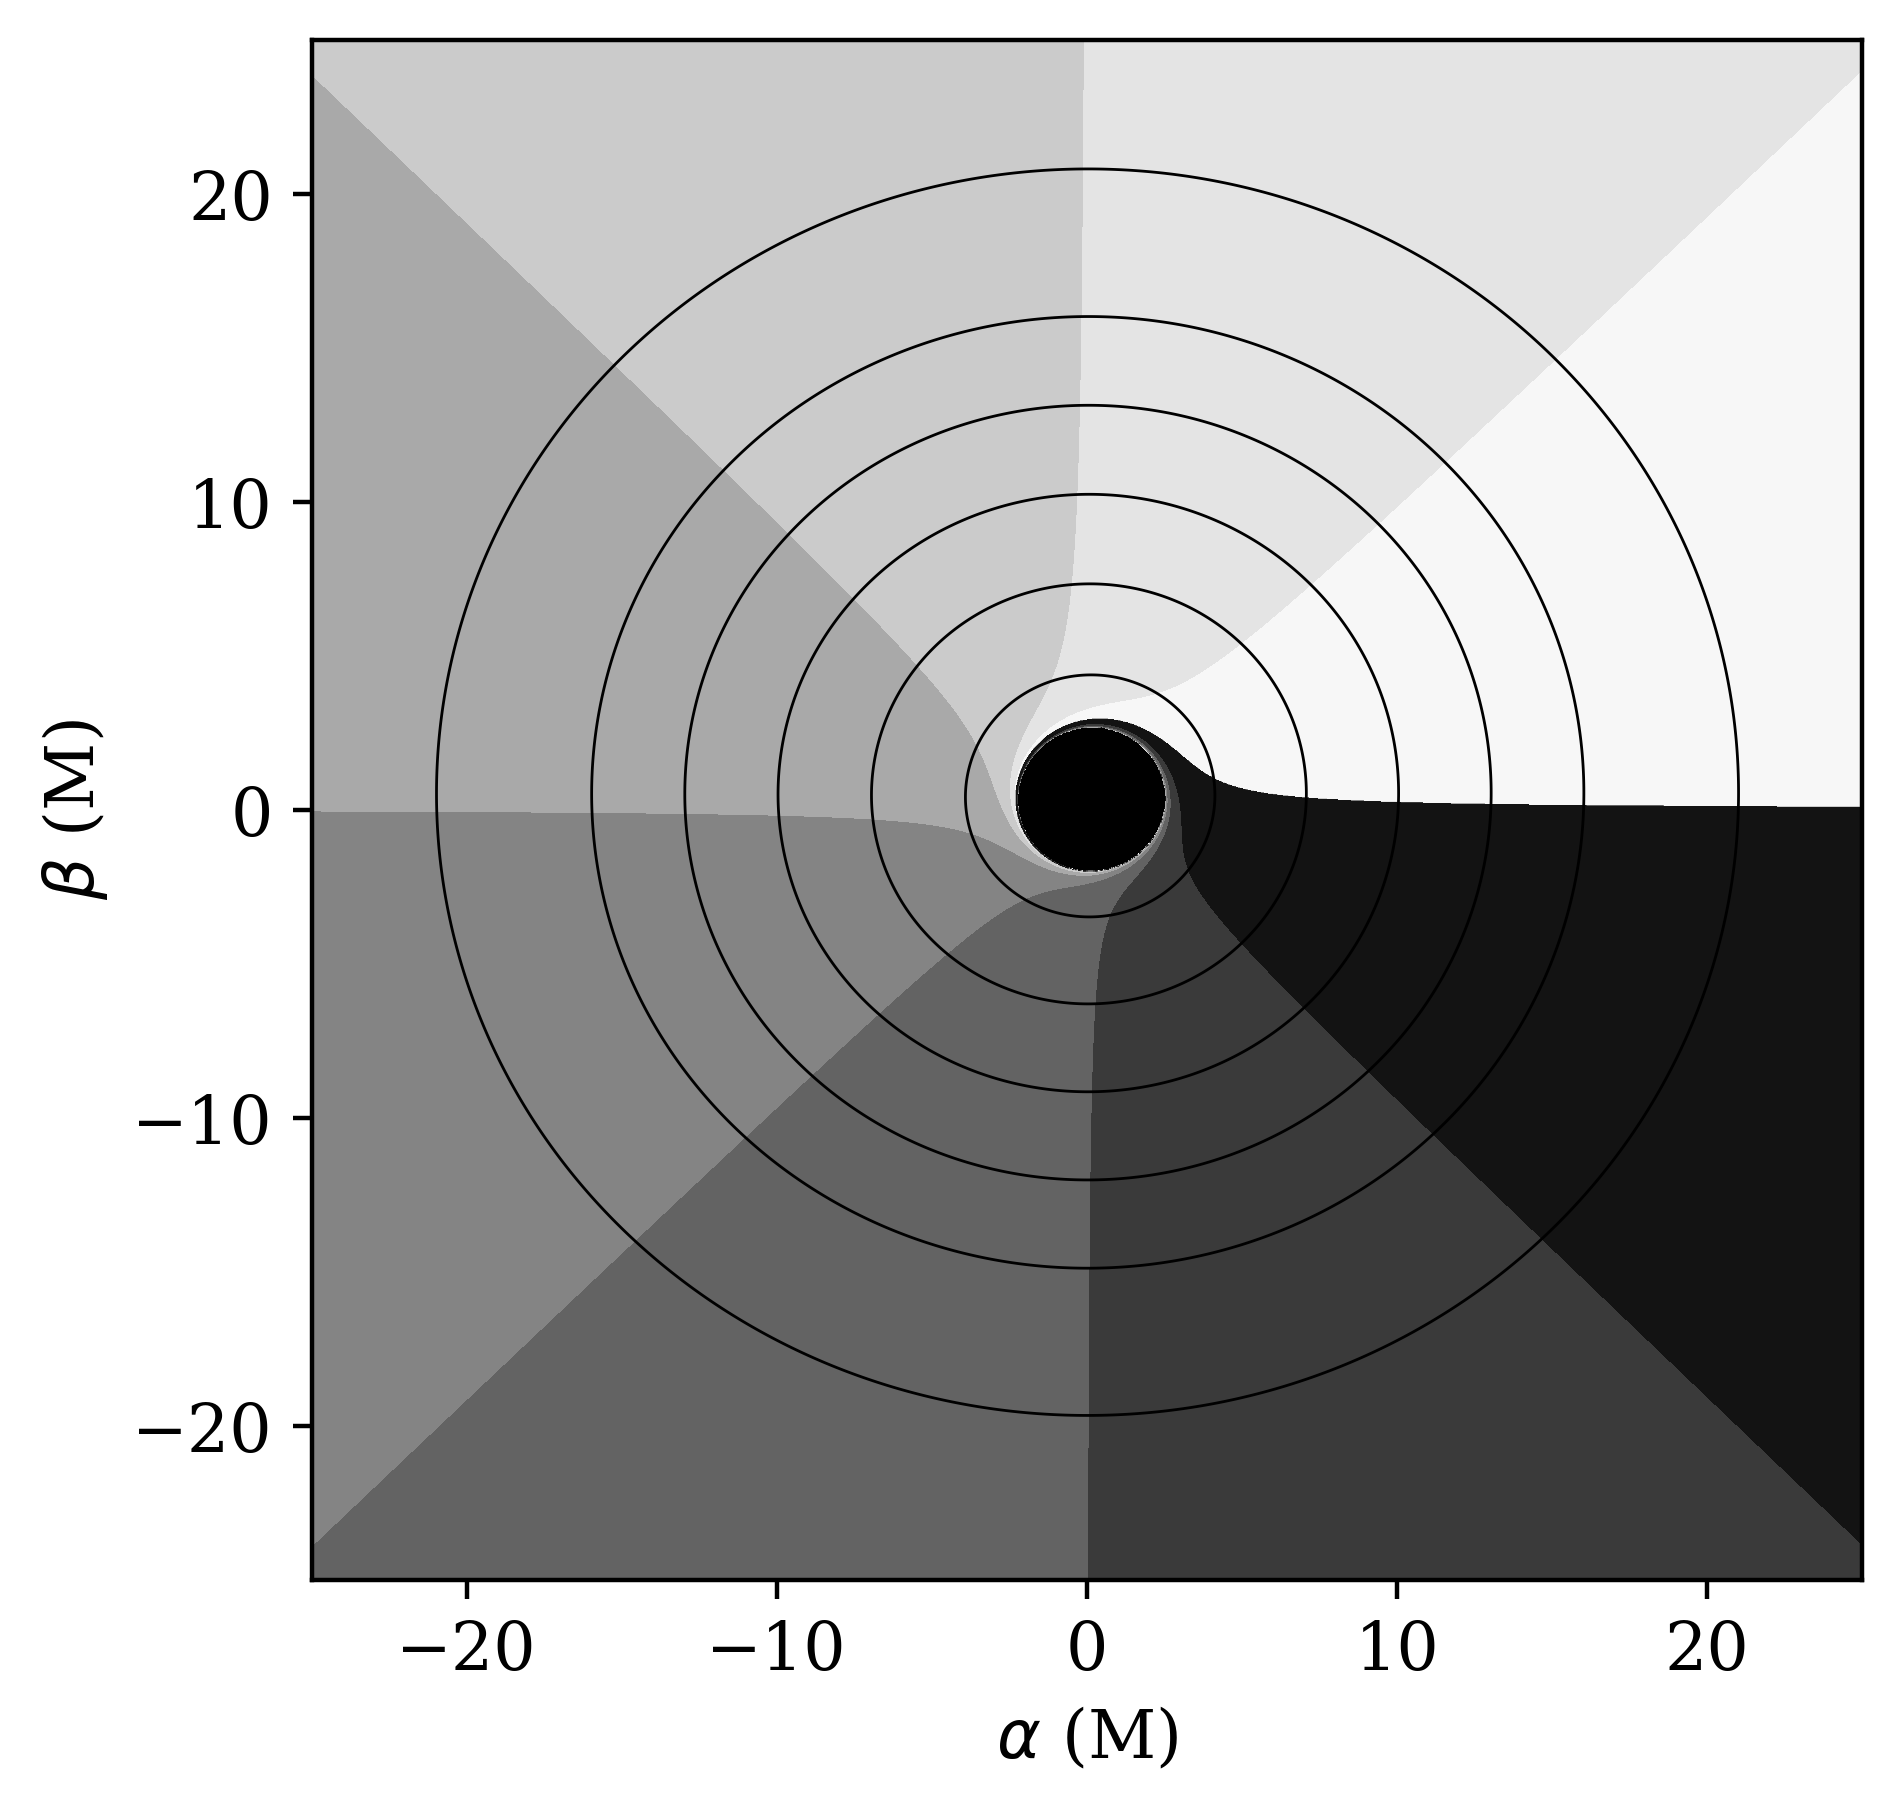

In [7]:
fig, ax = plt.subplots(figsize=[5,5],dpi=400)

ax.fill(hull_0i[:,0],hull_0i[:,1],color="k",linewidth=1,zorder=0)
        
CSphi=ax.contourf(phi0.reshape(N0,N0).T%(2*np.pi),cmap="Greys",levels=np.linspace(0,2*np.pi,9),extent=[-lim0,lim0,-lim0,lim0],origin="lower")
CSr=ax.contour(rs0.reshape(N0,N0).T,levels=[3,6,9,12,15,20],extent=[-lim0,lim0,-lim0,lim0],origin="lower",linewidths=0.5,colors='k')

ax.set_xlim(-lim0,lim0)
ax.set_ylim(-lim0,lim0)

ax.set_xlabel(r"$\alpha$"+" "+"(M)")
ax.set_ylabel(r"$\beta$"+" "+"(M)")

#plt.savefig('Rays.png',dpi=400,bbox_inches='tight')

# Computing images

In [4]:

args = ' '
cmd1_args = {
   	"nu0" : '--nu ',
	"mass" : '--mass ',
	"scale_height" : '--scaleh ',
	"theta_b" : '--thetab ',
	"beta" : '--beta ',
    "r_ie" : '--rie ',
	"rb_0" : '--rb0 ',
	"n_th0" : '--nth0 ',
	"t_e0" : '--te0 ',
	"p_dens" : '--pdens ',
	"p_temp" : '--ptemp ',
    "nscale" : '--nscale ',
}

cmd2_args = {
	"absorbkey" : '--absorbkey ',
	"emodelkey" : '--emodelkey ',
    "bkey" : '--bkey ',
    "nnoisykey" : '--nnoisykey ',
    "tnoisykey" : '--tnoisykey ',
    "bnoisykey" : '--bnoisykey ',
}
# brightparams = [
# 	230e9, # nu0
# 	(MMkg * u.kg).to(u.g).value, # mass
# 	.5, # scale_height
# 	50.0 * (np.pi / 180), # theta_b
# 	1.0, # beta
# 	10.0, # Rie
# 	0, # Bchoice
# 	2, # rb
# 	1.0726e+05, # n_th0
# 	1.2428e+11, # t_e0
# 	-.7, # p_dens
# 	-.84 # p_temp
# ]
brightparams = {
	"nu0" : 230e9, # 0 nu0
	"mass" : (MMkg * u.kg).to(u.g).value, # 1 mass
	"scale_height" : .5, # 2 scale_height
	"theta_b" : 50.0 * (np.pi / 180), # 3 theta_b
	"beta" : 1.0, # 4 beta
	"r_ie" : 10.0, # 5 rie
	"rb_0" : 2, # 7 rb_0
	"n_th0" : 1e5, # 8 n_th0
	"t_e0" : 1e11, # 9 t_e0
	"p_dens" : -.7, # 10 p_dens
	"p_temp" : -.84, # 11 p_temp
    "nscale" : .4 # Scale of Inoisy
}

funckeys = {
        "absorbkey" : 0, # absorbkey
		"emodelkey" : 0, # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law
        "bkey" : 0, # bkey
        "nnoisykey" : 1, # nnoisykey Inoisy density. 0 = no noise, 1 = noise
        "tnoisykey" : 0, # tnoisykey Inoisy temperature
        "bnoisykey" : 0# bnoisykey Inoisy magnetic field
}


i = 0
for arg in cmd1_args:
    args = args + cmd1_args[arg] + str(brightparams[arg]) + ' ' 
    i += 1

i = 0
for arg in cmd2_args:
    args = args + cmd2_args[arg] + str(funckeys[arg]) + ' ' 
    
# for i in range(len(brightparams)):
#     args = args + cmd1_args[i] + str(brightparams[i]) + ' '
aartpath = '/home/tej/Desktop/Code_Stuff/Repositories/aart'

In [6]:
subprocess.run(['python3 ' + aartpath + '/radialintensity.py' + args], shell=True)


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Reading file:  ./Results/Rays_a_0.94_i_17.h5
Intensity
Reading file:  ./Results/LensingBands_a_0.94_i_17.h5
Reading file:  ./Results/Rays_a_0.94_i_17.h5
(6250000,)
(6250000,)
(6250000,)
File  ./Results/Intensity_a_0.94|i_17|nu_2.3e+11|mass_1.3e+43|scaleh_0.5|thetab_0.873|beta_1.00|rie_10.0|rb_2.0|nth0_1.0e+05|te0_1.0e+11|pdens_-0.7|ptemp_-0.84|nscale_0.4|abkey_0|emkey_0|bkey_0|nkey_1|tnkey_0|bnkey_0.h5  created.


CompletedProcess(args=['python3 /home/tej/Desktop/Code_Stuff/Repositories/aart/radialintensity.py --nu 230000000000.0 --mass 1.3249659172847406e+43 --scaleh 0.5 --thetab 0.8726646259971648 --beta 1.0 --rie 10.0 --rb0 2 --nth0 100000.0 --te0 100000000000.0 --pdens -0.7 --ptemp -0.84 --nscale 0.4 --absorbkey 0 --emodelkey 0 --bkey 0 --nnoisykey 1 --tnoisykey 0 --bnoisykey 0 '], returncode=0)

In [7]:
# TODO: modify name
fnrays='./Results/Intensity_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|abkey_{}|emkey_{}|bkey_{}|nkey_{}|tnkey_{}|bnkey_{}.h5'.format(
    spin_case,
    i_case,
    "{:.1e}".format(brightparams["nu0"]),
    "{:.1e}".format(brightparams["mass"]), 
    float(brightparams["scale_height"]),
    "{:.3f}".format(brightparams["theta_b"]), 
    "{:.2f}".format(float(brightparams["beta"])),
    "{:.1f}".format(float(brightparams["r_ie"])), 
    "{:.1f}".format(float(brightparams["rb_0"])),
    "{:.1e}".format(brightparams["n_th0"]),
    "{:.1e}".format(brightparams["t_e0"]),
    float(brightparams["p_dens"]),
    float(brightparams["p_temp"]),
    "{:.1f}".format(brightparams["nscale"]),
    funckeys["absorbkey"],
    funckeys["emodelkey"],
    funckeys["bkey"],
    funckeys["nnoisykey"],
    funckeys["tnoisykey"],
    funckeys["bnoisykey"]
    )
    
print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

I0=h5f['bghts0'][:] # This implies I0 is 1 pass
I1=h5f['bghts1'][:]
I2=h5f['bghts2'][:]

h5f.close()



Reading file:  ./Results/Intensity_a_0.94|i_17|nu_2.3e+11|mass_1.3e+43|scaleh_0.5|thetab_0.873|beta_1.00|rie_10.0|rb_2.0|nth0_1.0e+05|te0_1.0e+11|pdens_-0.7|ptemp_-0.84|nscale_0.4|abkey_0|emkey_0|bkey_0|nkey_1|tnkey_0|bnkey_0.h5


'Radii Calc'

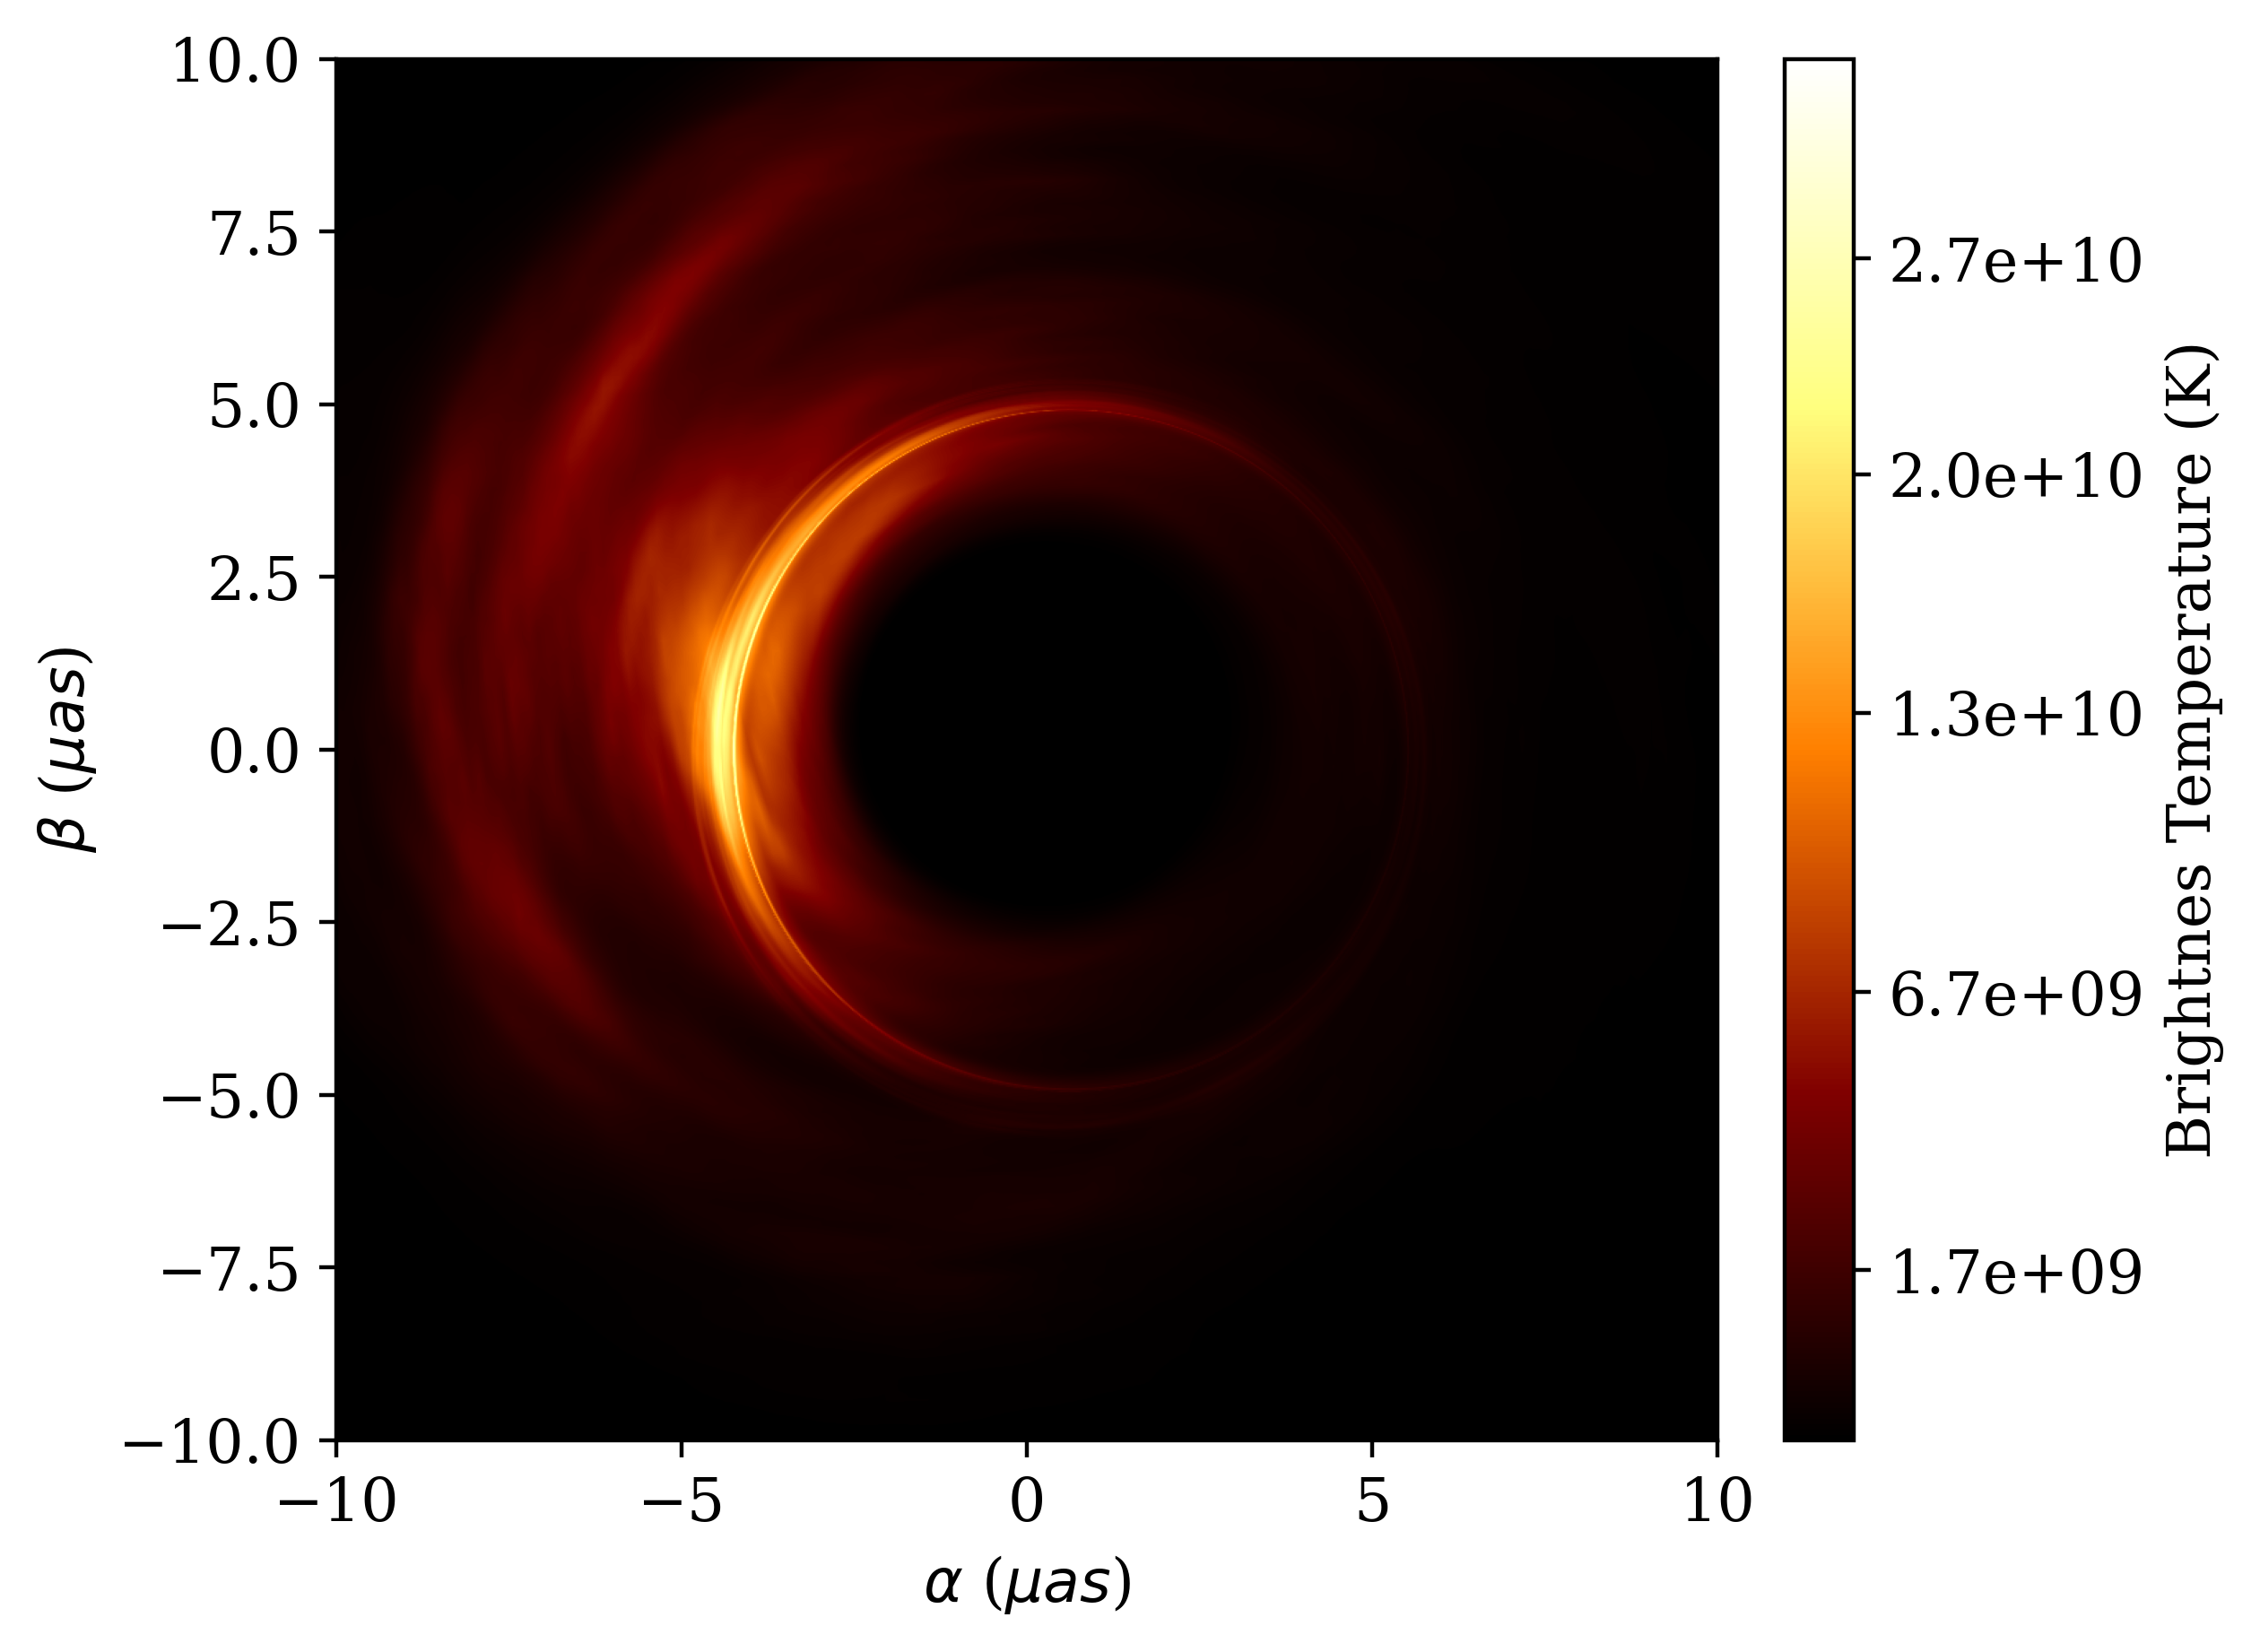

In [8]:
# one_M = ilp.rg_func(brightparams[1] * u.g).to(u.m)
# M2rads = np.arctan(one_M.value / dBH)
# M2uas = np.arctan(one_M.value / dBH)/muas_to_rad
# Mass distance units of 1 = .5842 uas

vmax = np.max(I0+I1+I2)*1.2
vmin = np.max(I0+I1+I2)* .1
fig, ax = plt.subplots(figsize=[6,5],dpi=400)
#im = ax.imshow(I0+I1+I2,vmax=np.max(I0+I1+I2)*1.2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
im = ax.imshow(I0+I1+I2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],
               norm=matplotlib.colors.PowerNorm(.7,vmax=vmax))

#im = ax.imshow(blurred,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])


ax.set_xlim(-10,10) # units of M
ax.set_ylim(-10,10) 
    
ax.set_xlabel(r"$\alpha$"+" "+r"($\mu as$)")
ax.set_ylabel(r"$\beta$"+" "+r"($\mu as$)")

# ax.set_xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10], labels=[
#     str('{:.3}'.format(-10 * M2uas)),
#     str('{:.3}'.format(-7.5 * M2uas)),
#     str('{:.3}'.format(-5 * M2uas)),
#     str('{:.3}'.format(-2.5 * M2uas)),
#     str('{:.3}'.format(0 * M2uas)),
#     str('{:.3}'.format(2.5 * M2uas)),
#     str('{:.3}'.format(5 * M2uas)), 
#     str('{:.3}'.format(7.5 * M2uas)), 
#     str('{:.3}'.format(10 * M2uas))
#     ])

# ax.set_yticks([-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10], labels=[
#     str('{:.3}'.format(-10 * M2uas)),
#     str('{:.3}'.format(-7.5 * M2uas)),
#     str('{:.3}'.format(-5 * M2uas)),
#     str('{:.3}'.format(-2.5 * M2uas)),
#     str('{:.3}'.format(0 * M2uas)),
#     str('{:.3}'.format(2.5 * M2uas)),
#     str('{:.3}'.format(5 * M2uas)), 
#     str('{:.3}'.format(7.5 * M2uas)), 
#     str('{:.3}'.format(10 * M2uas))
#     ])



colorbar=plt.colorbar(im, fraction=0.046, pad=0.04, format='%.1e', ticks=[
    vmax*.8,
    vmax*.6,
    vmax*.4,
    vmax*.2,
    vmax*.05
    ],
    label="Brightnes Temperature (K)"
    )

'''Radii Calc'''
# radius = tls.radii_of_theta(I0,100)
# theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1) / 100)
# radius1 = tls.radii_of_theta(I1,100)
# radius2 = tls.radii_of_theta(I2,100)

# alpha =  radius * np.cos(theta)
# beta =  radius * np.sin(theta)
# alpha1 =  radius1 * np.cos(theta)
# beta1 =  radius1 * np.sin(theta)
# alpha2 =  radius2 * np.cos(theta)
# beta2 =  radius2 * np.sin(theta)

# plt.plot(alpha, beta, 'b')
# plt.plot(alpha2, beta2, 'r')
# plt.plot(alphas_inner, betas_inner, '--c')
# plt.plot(alphas_outer, betas_outer, '--m')

# theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1)/100)
# radii = np.array(tls.radii_of_theta(I0,100)) /100
# beta =  radii * np.sin(theta)
# alpha =  radii * np.cos(theta)
# plt.plot(alpha, beta, 'r')



# plt.savefig(
#     'Images/BHImage_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|abkey_{}|emkey_{}|bkey_{}|nkey_{}|tnkey_{}|bnkey_{}.png'.format(
#     spin_case,
#     i_case,
#     "{:.1e}".format(brightparams["nu0"]),
#     "{:.1e}".format(brightparams["mass"]), 
#     float(brightparams["scale_height"]),
#     "{:.3f}".format(brightparams["theta_b"]), 
#     "{:.2f}".format(float(brightparams["beta"])),
#     "{:.1f}".format(float(brightparams["r_ie"])), 
#     "{:.1f}".format(float(brightparams["rb_0"])),
#     "{:.1e}".format(brightparams["n_th0"]),
#     "{:.1e}".format(brightparams["t_e0"]),
#     float(brightparams["p_dens"]),
#     float(brightparams["p_temp"]),
#     "{:.1f}".format(brightparams["nscale"]),
#     funckeys["absorbkey"],
#     funckeys["emodelkey"],
#     funckeys["bkey"],
#     funckeys["nnoisykey"],
#     funckeys["tnoisykey"],
#     funckeys["bnoisykey"]
#     )
# )
# plt.show()

## INOISY

In [51]:
def profile(r,gammap,mup,sigmap):
    return np.exp(-(1/2)*(gammap+ np.arcsinh((r-mup)/sigmap))**2)/np.sqrt((r-mup)**2+sigmap**2)


GRF=np.load("Inoisysnapshot.npy")
            
Xs=np.arange(-30,30,0.1171875)
Ys=np.arange(-30,30,0.1171875)
xx, yy = np.meshgrid(Xs, Ys)
radius=np.sqrt(xx**2 + yy**2)
Pgamma=-3/2
Pmu=1-np.sqrt(1-0.94**2)
Psigma=1/2
horizon=1+np.sqrt(1-0.94**2)
rows, cols =np.where(radius<horizon)
envelope=profile(radius,Pgamma,Pmu,Psigma)
scale=0.4
density=envelope*np.exp(scale*GRF-scale**2/2)

density_interp = RegularGridInterpolator((Xs,Ys), density,fill_value=0,bounds_error=False,method='linear')

In [56]:
density_interp(np.vstack([x_aux,y_aux]).T).shape


(6206651,)

In [ ]:
test = [1,1,1]
test1 = [0,0,0]

In [57]:
ilp.h.unit

Unit("erg s")

In [37]:
np.vstack([x_aux[rs>=isco],y_aux[rs>=isco]]).T.shape

(6178440, 2)

In [35]:
rs = rs0[mask0]
th = phi0[mask0]
x_aux=rs*np.cos(th)
y_aux=rs*np.sin(th)
x_aux[rs>=isco].shape

(6178440,)

In [17]:

print(phi0[0])
print(phi0[len(phi0)-1])
print(np.pi)

-2.335108462901789
0.8057697745505825
3.141592653589793


In [44]:
hf = h5py.File(i_fname, 'r')

data = np.array(hf['data/data_env'])
#inoisy has periodic boudaries, so we need to copy wrap the data with one frame
data=np.concatenate((data,data[0,:,:][np.newaxis,:,:]),axis=0)
data=np.flip(data,axis=(2))

nt = data.shape[0] #inoisy time resolution
ni = data.shape[1] #inoisy x resolution
nj = data.shape[2] #inoisy y resolution

xtstart = np.array(hf['params/x0start'])[0]
xtend = np.array(hf['params/x0end'])[0]

x1start = np.array(hf['params/x1start'])[0]
x2start = np.array(hf['params/x2start'])[0]

x1end = np.array(hf['params/x1end'])[0]
x2end = np.array(hf['params/x2end'])[0]

x1 = np.linspace(x1start, x1end, ni) 
x2 = np.linspace(x2start, x2end, nj)

times = np.linspace(xtstart, xtend, nt) 

h5py.File.close(hf)

In [9]:
fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]

h5f.close()

Reading file:  ./Results/Rays_a_0.94_i_17.h5


In [22]:
fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])

h5f.close()

Reading file:  ./Results/LensingBands_a_0.94_i_17.h5


In [56]:
r_array = np.logspace(np.log10(2), np.log10(50)) * u.dimensionless_unscaled

def j_coeff_func(r, redshift, nu0=ilp.kw_nu0,mass=ilp.kw_mass, theta_b=ilp.kw_theta_b, 
            beta=ilp.kw_beta,rb_0=ilp.kw_rb_0,n_th0=ilp.kw_n_th0,t_e0=ilp.kw_t_e0,p_dens=ilp.kw_p_dens,p_temp=ilp.kw_p_temp):
    n = ilp.nth_func(r,mass,rb_0,n_th0,p_dens)
    theta_e = ilp.theta_e_func(r,mass,rb_0,t_e0,p_temp)
    nu_c = ilp.nu_c_func(r,mass,theta_b,rb_0,t_e0,p_temp)
    nu = nu0/redshift
    x = nu / (nu_c)
    # Returns units of [u.erg / (u.cm ** 3 * u.s * u.Hz)]
    return n * ilp.e ** 2 * nu * ilp.synchrotron_func(x) / (2 * np.sqrt(3) * ilp.c * theta_e ** 2)

## G function tests

In [12]:
# Assume d log is natural log, & is for end of line
gxvalsarray = np.array([1.e-6, 1.12202e-6, 1.25893e-6, 1.41254e-6, 1.58489e-6, 1.77828e-6, 1.99526e-6, 2.23872e-6, 2.51189e-6,2.81838e-6, 3.16228e-6, 3.54813e-6, 3.98107e-6, 
              4.46684e-6, 5.01187e-6, 5.62341e-6, 6.30957e-6, 7.07946e-6, 7.94328e-6, 8.91251e-6, 0.00001e0, 0.0000112202e0, 0.0000125893e0, 0.0000141254e0,
              0.0000158489e0, 0.0000177828e0, 0.0000199526e0, 0.0000223872e0, 0.0000251189e0, 0.0000281838e0, 0.0000316228e0, 0.0000354813e0, 0.0000398107e0,
              0.0000446684e0, 0.0000501187e0, 0.0000562341e0, 0.0000630957e0, 0.0000707946e0, 0.0000794328e0, 0.0000891251e0, 0.0001e0, 0.000112202e0, 0.000125893e0, 
              0.000141254e0, 0.000158489e0, 0.000177828e0, 0.000199526e0, 0.000223872e0, 0.000251189e0, 0.000281838e0, 0.000316228e0, 0.000354813e0, 0.000398107e0, 0.000446684e0,
              0.000501187e0, 0.000562341e0, 0.000630957e0, 0.000707946e0, 0.000794328e0, 0.000891251e0, 0.001e0, 0.00112202e0, 0.00125893e0, 0.00141254e0, 
              0.00158489e0, 0.00177828e0, 0.00199526e0, 0.00223872e0, 0.00251189e0, 0.00281838e0, 0.00316228e0, 0.00354813e0, 0.00398107e0, 0.00446684e0, 0.00501187e0,
              0.00562341e0, 0.00630957e0, 0.00707946e0, 0.00794328e0, 0.00891251e0, 0.01e0, 0.0112202e0, 0.0125893e0, 0.0141254e0, 0.0158489e0, 0.0177828e0,
              0.0199526e0, 0.0223872e0, 0.0251189e0, 0.0281838e0, 0.0316228e0, 0.0354813e0, 0.0398107e0, 0.0446684e0, 0.0501187e0, 0.0562341e0, 0.0630957e0, 0.0707946e0,
              0.0794328e0, 0.0891251e0, 0.1e0, 0.112202e0, 0.125893e0, 0.141254e0, 0.158489e0, 0.177828e0, 0.199526e0, 0.223872e0, 0.251189e0, 0.281838e0, 0.316228e0, 0.354813e0, 0.398107e0, 0.446684e0,
              0.501187e0, 0.562341e0, 0.630957e0, 0.707946e0, 0.794328e0, 0.891251e0, 1e0, 1.12202e0, 1.25893e0, 1.41254e0, 1.58489e0, 1.77828e0, 1.99526e0, 2.23872e0, 2.51189e0, 2.81838e0, 
              3.16228e0, 3.54813e0, 3.98107e0, 4.46684e0, 5.01187e0, 5.62341e0, 6.30957e0, 7.07946e0, 7.94328e0, 8.91251e0, 10e0, 11.2202e0, 12.5893e0, 14.1254e0, 15.8489e0, 
              17.7828e0, 19.9526e0, 22.3872e0, 25.1189e0, 28.1838e0, 31.6228e0, 35.4813e0, 39.8107e0, 44.6684e0, 50.1187e0, 56.2341e0, 63.0957e0, 70.7946e0, 79.4328e0, 
              89.1251e0, 100e0, 112.202e0, 125.893e0, 141.254e0, 158.489e0, 177.828e0, 199.526e0, 223.872e0, 251.189e0, 281.838e0, 316.228e0, 354.813e0, 398.107e0, 446.684e0, 
              501.187e0, 562.341e0, 630.957e0, 707.946e0, 794.328e0, 891.251e0, 1000e0])
gxvals=np.log(gxvalsarray)




In [23]:
xvalsarray = np.array([1.e-6, 1.25893e-6, 1.58489e-6, 1.99526e-6, 2.51189e-6,3.16228e-6, 3.98107e-6, 5.01187e-6, 6.30957e-6, 7.94328e-6, 0.00001e0, 0.0000125893e0, 0.0000158489e0, 0.0000199526e0,
          0.0000251189e0, 0.0000316228e0, 0.0000398107e0, 0.0000501187e0, 0.0000630957e0, 0.0000794328e0, 0.0001e0, 0.000125893e0, 0.000158489e0, 0.000199526e0, 
          0.000251189e0, 0.000316228e0, 0.000398107e0, 0.000501187e0, 0.000630957e0, 0.000794328e0, 0.001e0, 0.00125893e0, 0.00158489e0, 0.00199526e0, 0.00251189e0, 
          0.00316228e0, 0.00398107e0, 0.00501187e0, 0.00630957e0, 0.00794328e0, 0.01e0, 0.0125893e0, 0.0158489e0, 0.0199526e0, 0.0251189e0, 0.0316228e0, 0.0398107e0, 
          0.0501187e0, 0.0630957e0, 0.0794328e0, 0.1e0, 0.125893e0, 0.158489e0, 0.199526e0, 0.251189e0, 0.316228e0, 0.398107e0, 0.501187e0, 0.630957e0, 0.794328e0, 1e0, 
          1.25893e0, 1.58489e0, 1.99526e0, 2.51189e0, 3.16228e0, 3.98107e0, 5.01187e0, 6.30957e0, 7.94328e0, 10e0, 12.5893e0, 15.8489e0, 19.9526e0, 25.1189e0, 31.6228e0, 
          39.8107e0, 50.1187e0, 63.0957e0, 79.4328e0, 100e0])
xvals=np.log(xvalsarray)

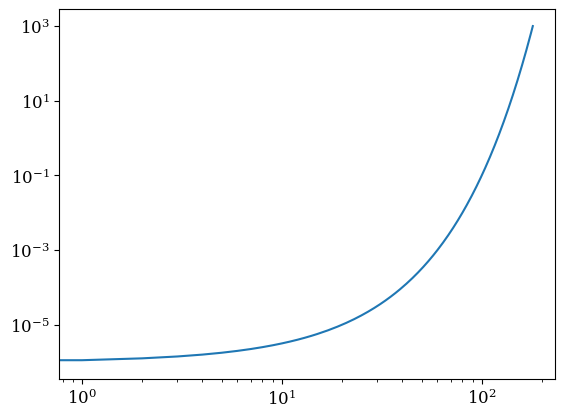

In [25]:
plt.plot(gxvalsarray)
plt.xscale('log')
plt.yscale('log')

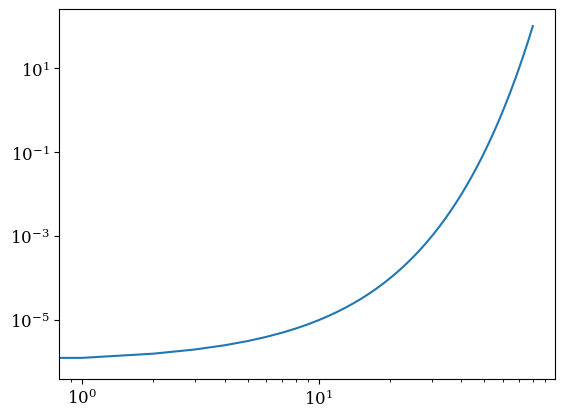

In [24]:
plt.plot(xvalsarray)
plt.xscale('log')
plt.yscale('log')

ValueError: x and y must have same first dimension, but have shapes (81,) and (181,)

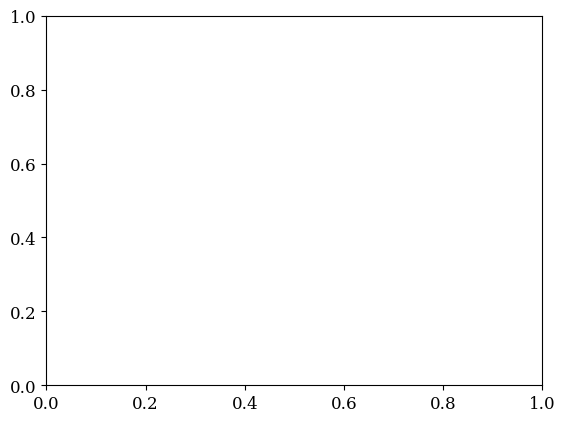

In [26]:
plt.plot(xvals,gxvals)

In [48]:
test =np.load("Inoisysnapshot.npy")
print(test.)

(512, 512)


In [20]:
def hi(string, inte):
    return string + str(inte)

def by(int):
    return int

In [21]:
hi("test", 1)
by(1)

1

In [24]:
test = {
    1 : hi("Test",1),
    2 : by(1)
}
print(test[2])

1


In [58]:
dict[0]() + 2

hiHI: 1


3

In [56]:
dict = {
    0: partial(test, "hi", 1),
    1: partial(test, "by", 2)
    }

In [55]:
def test(stri, int):
    print(stri + "HI: " + str(int))
    return 1

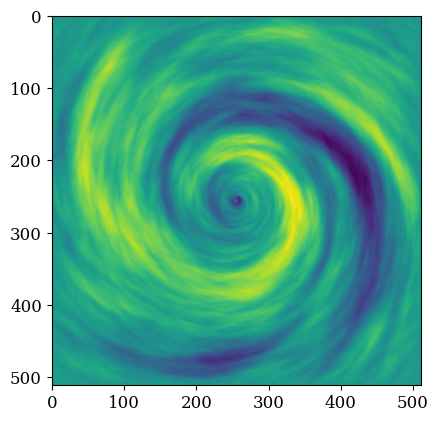

In [47]:
plt.imshow(test)